<a href="https://colab.research.google.com/github/triandosimarmata/myprojects/blob/main/LM_CMAES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[LM-Rosenbrock] Iter   100 | Best f(x)=1.455764e+04 | sigma=2.150e-01
[LM-Rosenbrock] Iter   200 | Best f(x)=5.658443e+03 | sigma=1.315e-01
[LM-Rosenbrock] Iter   300 | Best f(x)=2.737176e+03 | sigma=8.359e-02
[LM-Rosenbrock] Iter   400 | Best f(x)=1.578733e+03 | sigma=5.639e-02
[LM-Rosenbrock] Iter   500 | Best f(x)=1.000144e+03 | sigma=4.016e-02
[LM-Rosenbrock] Iter   600 | Best f(x)=7.744509e+02 | sigma=2.669e-02
[LM-Rosenbrock] Iter   700 | Best f(x)=6.393172e+02 | sigma=1.849e-02
[LM-Rosenbrock] Iter   800 | Best f(x)=5.714663e+02 | sigma=1.353e-02
[LM-Rosenbrock] Iter   900 | Best f(x)=5.281050e+02 | sigma=1.081e-02
[LM-Rosenbrock] Iter  1000 | Best f(x)=5.071964e+02 | sigma=8.095e-03
[LM-Rosenbrock] Iter  1100 | Best f(x)=4.996966e+02 | sigma=5.112e-03
[LM-Rosenbrock] Iter  1200 | Best f(x)=4.964757e+02 | sigma=3.011e-03
[LM-Rosenbrock] Iter  1300 | Best f(x)=4.953012e+02 | sigma=1.784e-03
[LM-Rosenbrock] Iter  1400 | Best f(x)=4.948257e+02 | sigma=1.069e-03
[LM-Rosenbrock] Iter

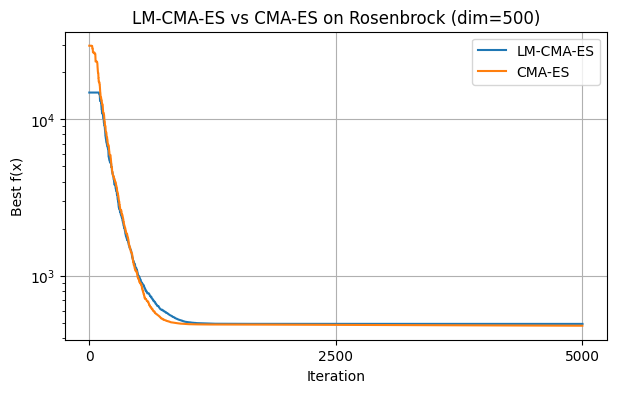

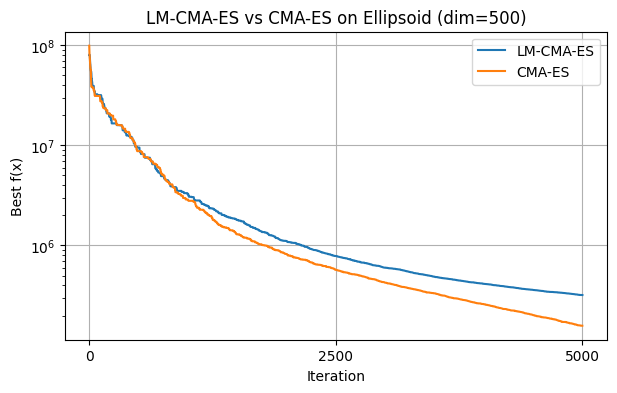

In [25]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Comparison of LM-CMA-ES (pure Python) and CMA-ES (from cma library)
on Rosenbrock and Ellipsoid benchmark functions.
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatterSciNotation
from dataclasses import dataclass, field
from typing import Callable, List, Tuple
import cma  # pip install cma

# ---------------------- Benchmark Functions ----------------------

def rosenbrock(x: np.ndarray) -> float:
    return float(np.sum(100.0 * (x[1:] - x[:-1] ** 2)**2 + (1.0 - x[:-1])**2))

def ellipsoid(x: np.ndarray) -> float:
    n = x.size
    exps = np.linspace(0.0, 6.0, n)
    weights = 10.0 ** exps
    return float(np.sum(weights * x**2))

# ---------------------- LM-CMA-ES Implementation ----------------------

@dataclass
class LMHistoryVec:
    u: np.ndarray
    a: float

@dataclass
class LMCMAES:
    dim: int
    popsize: int | None = None
    sigma0: float = 0.3
    memory: int = 12
    seed: int | None = None
    mu_frac: float = 0.5

    c_sigma: float = field(init=False)
    d_sigma: float = field(init=False)
    c_c: float = field(init=False)
    mu_eff: float = field(init=False)
    weights: np.ndarray = field(init=False)
    rng: np.random.Generator = field(init=False)
    m: np.ndarray = field(init=False)
    sigma: float = field(init=False)
    p_sigma: np.ndarray = field(init=False)
    p_c: np.ndarray = field(init=False)
    hist: List[LMHistoryVec] = field(default_factory=list)

    def __post_init__(self):
        if self.popsize is None:
            self.popsize = 4 + int(3 * np.log(self.dim))
        mu = max(1, int(self.mu_frac * self.popsize))
        w = np.log(mu + 0.5) - np.log(np.arange(1, mu + 1))
        self.weights = w / np.sum(w)
        self.mu_eff = 1.0 / np.sum(self.weights**2)

        self.c_sigma = (self.mu_eff + 2) / (self.dim + self.mu_eff + 5)
        self.d_sigma = 1 + 2 * max(0, np.sqrt((self.mu_eff - 1) / (self.dim + 1)) - 1) + self.c_sigma
        self.c_c = (4 + self.mu_eff / self.dim) / (self.dim + 4 + 2 * self.mu_eff / self.dim)

        self.rng = np.random.default_rng(self.seed)
        self.m = np.zeros(self.dim)
        self.sigma = float(self.sigma0)
        self.p_sigma = np.zeros(self.dim)
        self.p_c = np.zeros(self.dim)

    def apply_A(self, z: np.ndarray) -> np.ndarray:
        y = z.copy()
        for hv in self.hist:
            y += hv.a * np.dot(hv.u, y) * hv.u
        return y

    def ask(self) -> Tuple[np.ndarray, np.ndarray]:
        Z = self.rng.standard_normal((self.dim, self.popsize))
        Y = np.column_stack([self.apply_A(Z[:, i]) for i in range(self.popsize)])
        X = self.m.reshape(-1, 1) + self.sigma * Y
        return X, Z

    def tell(self, X: np.ndarray, Z: np.ndarray, fitness: np.ndarray):
        idx = np.argsort(fitness)
        X, Z = X[:, idx], Z[:, idx]
        parents = X[:, :len(self.weights)]
        parents_Z = Z[:, :len(self.weights)]

        m_old = self.m.copy()
        self.m = parents @ self.weights
        z_w = parents_Z @ self.weights

        self.p_sigma = (1 - self.c_sigma) * self.p_sigma + np.sqrt(
            self.c_sigma * (2 - self.c_sigma) * self.mu_eff
        ) * z_w
        chi_n = np.sqrt(self.dim) * (1 - 1/(4*self.dim) + 1/(21*self.dim**2))
        self.sigma *= np.exp((np.linalg.norm(self.p_sigma) / chi_n - 1) *
                             self.c_sigma / self.d_sigma)

        y_w = (self.m - m_old) / max(1e-12, self.sigma)
        self.p_c = (1 - self.c_c) * self.p_c + np.sqrt(
            self.c_c * (2 - self.c_c) * self.mu_eff
        ) * y_w

        norm_yw = np.linalg.norm(y_w)
        if norm_yw > 0:
            u = y_w / norm_yw
            a = min(0.5, 0.25 * self.c_c * np.sqrt(self.mu_eff / (self.dim + 1)))
            self.hist.append(LMHistoryVec(u, a))
            if len(self.hist) > self.memory:
                self.hist.pop(0)

    def run(self, f: Callable[[np.ndarray], float], max_iters=10000, tol=1e-12, name=""):
        best_x, best_f = self.m.copy(), f(self.m)
        history = [best_f]
        for it in range(1, max_iters + 1):
            X, Z = self.ask()
            fit = np.array([f(X[:, i]) for i in range(self.popsize)])
            i_best = fit.argmin()
            if fit[i_best] < best_f:
                best_f, best_x = float(fit[i_best]), X[:, i_best].copy()
            self.tell(X, Z, fit)
            history.append(best_f)
            if it % 100 == 0:
                print(f"[LM-{name}] Iter {it:5d} | Best f(x)={best_f:.6e} | sigma={self.sigma:.3e}")
            if best_f <= tol:
                break
        return history

# ---------------------- Comparison Runner ----------------------

def run_cma(func, name, dim, x0_scale=1.0, sigma0=0.5, max_iters=10000, seed=42):
    rng = np.random.default_rng(seed)
    x0 = rng.uniform(-x0_scale, x0_scale, size=dim)
    es = cma.CMAEvolutionStrategy(x0, sigma0, {'seed': seed, 'maxiter': max_iters})
    history = []
    while not es.stop():
        X = es.ask()
        fvals = [func(x) for x in X]
        es.tell(X, fvals)
        history.append(es.best.f)
        if es.result.iterations % 100 == 0:
            print(f"[CMA-{name}] Iter {es.result.iterations:5d} | Best f(x)={es.best.f:.6e}")
    return history

# ---------------------- Main ----------------------

def main():
    dim = 5000  # increase to 100+ to see memory advantage
    max_iters = 50000
    seed = 42

    for func, name, x0_scale, sigma0 in [
        (rosenbrock, "Rosenbrock", 0.8, 0.4),
        (ellipsoid, "Ellipsoid", 3.0, 1.0),
    ]:
        # LM-CMA-ES
        lm = LMCMAES(dim=dim, sigma0=sigma0, seed=seed)
        lm.m = lm.rng.uniform(-x0_scale, x0_scale, size=dim)
        hist_lm = lm.run(func, max_iters=max_iters, name=name)

        # CMA-ES (standard)
        hist_cma = run_cma(func, name, dim, x0_scale, sigma0, max_iters=max_iters, seed=seed)

        # Plot
        plt.figure(figsize=(7,4))
        plt.semilogy(hist_lm, label="LM-CMA-ES")
        plt.semilogy(hist_cma, label="CMA-ES")
        plt.xlabel("Iteration")
        plt.ylabel("Best f(x)")
        plt.title(f"LM-CMA-ES vs CMA-ES on {name} (dim={dim})")
        plt.xticks(range(0, max_iters+1, 2500))
        plt.gca().yaxis.set_major_formatter(LogFormatterSciNotation())
        plt.grid(True)
        plt.legend()

    plt.show()

if __name__ == "__main__":
    main()


ERROR: Could not find a version that satisfies the requirement pycma-lmcma (from versions: none)
ERROR: No matching distribution found for pycma-lmcma
